In [45]:
import pandas_datareader as pdr 
#Provides access to certain API for data eg. - Tiingo
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
import pandas as pd
import numpy as np

In [20]:
df = pd.read_html('https://www.eia.gov/opendata/qb.php?sdid=PET.RBRTE.D')

In [21]:
len(df)

1

In [22]:
df = df[0]

In [23]:
df.head()

,Series Name,Period,Frequency,Value,Units
0,"Europe Brent Spot Price FOB, Daily",20210727,D,74.87,Dollars per Barrel
1,"Europe Brent Spot Price FOB, Daily",20210726,D,74.79,Dollars per Barrel
2,"Europe Brent Spot Price FOB, Daily",20210723,D,74.86,Dollars per Barrel
3,"Europe Brent Spot Price FOB, Daily",20210722,D,74.25,Dollars per Barrel
4,"Europe Brent Spot Price FOB, Daily",20210721,D,72.54,Dollars per Barrel


In [24]:
df = df[['Period','Value']]

In [25]:
df

,Period,Value
0,20210727,74.87
1,20210726,74.79
2,20210723,74.86
3,20210722,74.25
4,20210721,72.54
...,...,...
8684,19870526,18.63
8685,19870525,18.60
8686,19870522,18.55
8687,19870521,18.45


In [27]:
df['Date'] = pd.to_datetime(df['Period'], format='%Y%m%d')

In [28]:
df

,Period,Value,Date
0,20210727,74.87,2021-07-27
1,20210726,74.79,2021-07-26
2,20210723,74.86,2021-07-23
3,20210722,74.25,2021-07-22
4,20210721,72.54,2021-07-21
...,...,...,...
8684,19870526,18.63,1987-05-26
8685,19870525,18.60,1987-05-25
8686,19870522,18.55,1987-05-22
8687,19870521,18.45,1987-05-21


In [29]:
df = df.drop('Period',axis = 1)

In [32]:
df = df.set_index('Date')

In [40]:
df = df[-1::-1]

In [41]:
df

,Value
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2021-07-21,72.54
2021-07-22,74.25
2021-07-23,74.86


<AxesSubplot:xlabel='Date'>

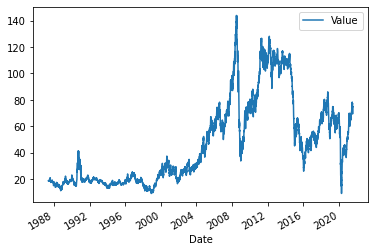

In [47]:
df.plot()

In [48]:
df1 = df.reset_index()['Value']

In [49]:
df1

0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
        ...  
8684    72.54
8685    74.25
8686    74.86
8687    74.79
8688    74.87
Name: Value, Length: 8689, dtype: float64

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [52]:
df1.shape

(8689, 1)

In [53]:
df1

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.48765295],
       [0.48713385],
       [0.4877271 ]])

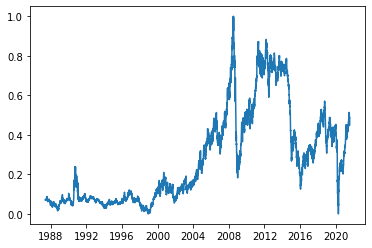

In [55]:
plt.plot(df.index,df1)

In [58]:
w = int(input(' Enter window size'))

 Enter window size100


In [111]:
training_size = int(len(df1)*0.96)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size+w,:],df1[training_size:len(df1),:]

In [112]:
train_data.shape, test_data.shape

((8441, 1), (348, 1))

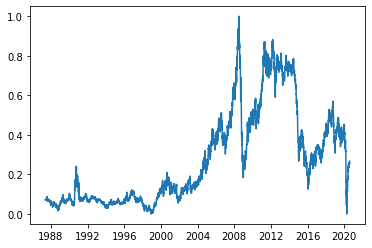

In [113]:
plt.plot(df.index[:training_size+100],train_data)


In [114]:
def create_dataset(dataset,time_step = 1):

    dataX, dataY = [],[]

    for i in range(len(dataset) - time_step):

        a = dataset[i:(i+time_step),0]   #i = 0 then 0,1,2,3 will be x and y = 4 (if our time step is 4)

        dataX.append(a)

        dataY.append(dataset[i+time_step,0])

    return np.array(dataX), np.array(dataY)

In [115]:
time_step = w
#Using 100 consecutive values predicting 101th value
#f1-------f100 = X
#f101 = y
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [116]:
X_train.shape,X_test.shape

((8341, 100), (248, 100))

In [117]:
#Making data 3D
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [118]:
X_train.shape,X_test.shape

((8341, 100, 1), (248, 100, 1))

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [120]:
model = Sequential() #sequential model
model.add(LSTM(50,return_sequences = True, input_shape = (100,1))) # input shape of batch
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [121]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100,batch_size = 64, verbose =1)

Epoch 1/100
131/131 [==============================] - 19s 106ms/step - loss: 0.0043 - val_loss: 6.9430e-04
Epoch 2/100
131/131 [==============================] - 16s 124ms/step - loss: 6.1358e-04 - val_loss: 3.8693e-04
Epoch 3/100
131/131 [==============================] - 14s 106ms/step - loss: 4.7249e-04 - val_loss: 5.1363e-04
Epoch 4/100
131/131 [==============================] - 14s 106ms/step - loss: 3.8759e-04 - val_loss: 3.6763e-04
Epoch 5/100
131/131 [==============================] - 15s 113ms/step - loss: 3.8655e-04 - val_loss: 2.9916e-04
Epoch 6/100
131/131 [==============================] - 18s 134ms/step - loss: 3.0185e-04 - val_loss: 2.6052e-04
Epoch 7/100
131/131 [==============================] - 19s 145ms/step - loss: 2.8616e-04 - val_loss: 2.1753e-04
Epoch 8/100
131/131 [==============================] - 17s 132ms/step - loss: 2.9325e-04 - val_loss: 2.2118e-04
Epoch 9/100
131/131 [==============================] - 18s 139ms/step - loss: 2.5720e-04 - val_loss: 1.9622e

131/131 [==============================] - 15s 111ms/step - loss: 7.6514e-05 - val_loss: 8.2497e-05
Epoch 74/100
131/131 [==============================] - 14s 110ms/step - loss: 7.4798e-05 - val_loss: 8.4673e-05
Epoch 75/100
131/131 [==============================] - 14s 110ms/step - loss: 8.4607e-05 - val_loss: 8.8523e-05
Epoch 76/100
131/131 [==============================] - 15s 111ms/step - loss: 7.7087e-05 - val_loss: 1.0466e-04
Epoch 77/100
131/131 [==============================] - 15s 114ms/step - loss: 7.6673e-05 - val_loss: 8.3896e-05
Epoch 78/100
131/131 [==============================] - 17s 133ms/step - loss: 7.6513e-05 - val_loss: 1.3094e-04
Epoch 79/100
131/131 [==============================] - 15s 117ms/step - loss: 7.5324e-05 - val_loss: 8.7419e-05
Epoch 80/100
131/131 [==============================] - 15s 112ms/step - loss: 7.4877e-05 - val_loss: 8.3195e-05
Epoch 81/100
131/131 [==============================] - 14s 110ms/step - loss: 8.1295e-05 - val_loss: 8.3795e

In [123]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [124]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [125]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

54.988198168989705

In [126]:
math.sqrt(mean_squared_error(y_test,test_predict))

56.271484738685864

In [127]:
train_predict.shape

(8341, 1)

In [128]:
test_predict.shape

(248, 1)

In [129]:
a = train_predict.reshape(train_predict.shape[0],)

In [130]:
b = test_predict.reshape(test_predict.shape[0],)

In [131]:
c = list(a)+list(b)

In [132]:
len(c)

8589

In [133]:
t = []
for i in range(100):
    t.append(np.NaN)

In [134]:
d = t+c

In [135]:
len(d)

8689

In [136]:
df['Predicted Price'] = d

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [137]:
df

,Value,Predicted DHP,Predicted Price
Date,,,
1987-05-20,18.63,NaN,NaN
1987-05-21,18.45,NaN,NaN
1987-05-22,18.55,NaN,NaN
1987-05-25,18.60,NaN,NaN
1987-05-26,18.63,NaN,NaN
...,...,...,...
2021-07-21,72.54,70.762794,68.250427
2021-07-22,74.25,73.455444,70.932068
2021-07-23,74.86,75.222710,72.542976


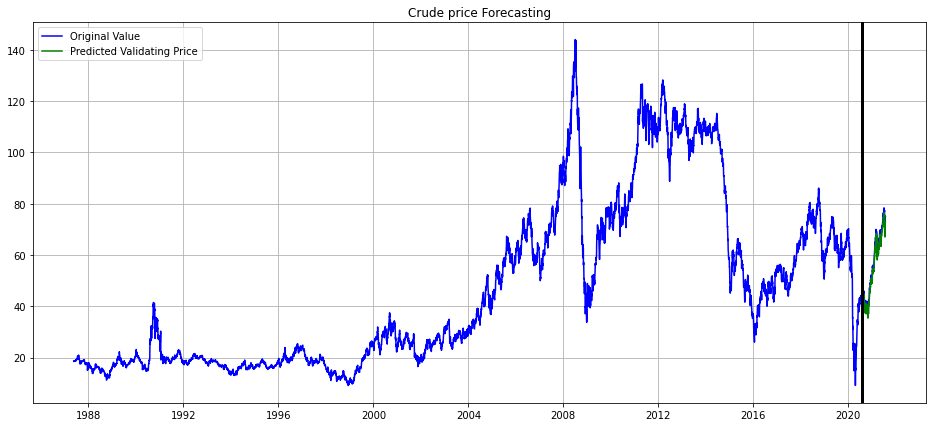

In [138]:
plt.figure(figsize = (16,7))
plt.grid(True)
plt.title('Crude price Forecasting')
plt.plot(df.index,df['Value'],label = "Original Value",c = 'blue')
#plt.plot(df[:train_predict.shape[0]+w].index,df['Predicted Price'][:train_predict.shape[0]+w],label = "Predicted Training Price",c = 'red')
plt.plot(df.index[train_predict.shape[0]+100:],df['Predicted Price'][train_predict.shape[0]+w:],label = "Predicted Validating Price", c = 'green')
plt.axvline(df.index[train_predict.shape[0]+w], color='black',lw=3)

plt.legend()